### 0. Import util libraries

In [1]:
import xarray as xr
import numpy as np
from matplotlib import rc

from inversion_sst_gp import (
    plot_helper,
    utils,
    other_methods,
    metrics,
    gp_regression,
)

rc("font", family="serif", serif=["Computer Modern"])
rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{amsmath}")

In [ ]:
# Plotting parameters
lonlims = [115, 118]
latlims = [-15.5, -12.5]

### 1. Fully observed

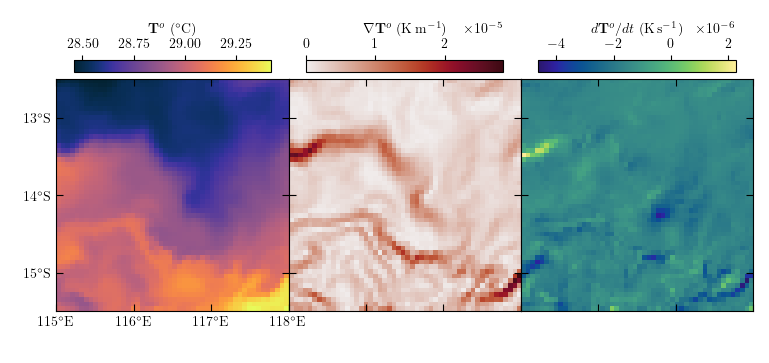

In [3]:
# Load dataset
ds = xr.open_dataset("data/suntans_1h.nc").sel(time=np.datetime64("2014-02-19T18:00:00"))
time_step = ds.time_step.item()
lon, lat, To, dTdto, u, v, S = (
    ds[var].values for var in ("lon", "lat", "T", "dTdt", "u", "v", "S")
)
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)
plot_helper.visualize_data(LON, LAT, To, dTdto, dTds1o, dTds2o, lonlims=lonlims, latlims=latlims)

In [ ]:
# GP regression
params_fully_obs_gp = utils.extract_params(
    "outputs/noise_gp_obs_t.csv", "noise_sd", 0, type="gp"
)
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, params_fully_obs_gp, X, Y, time_step
    )
)

metrics_gp = metrics.overview(
    u, v, muustar, muvstar, stdustar, stdvstar, print_bool=True
)

RMSE       : 0.04687
rho_mag    : 0.8764
phi        : -3.612
crps_norm  : 0.02662
coverage90 : 0.8424


In [5]:
# Global optimal solution
n_gos = int(utils.extract_params("outputs/noise_gos_t.csv", "noise_sd",0,type="gos")["n"])
ugos, vgos, Sgos = other_methods.calculate_prediction_gos(dTds1o, dTds2o, dTdto, n_gos)
metrics_gos = metrics.overview(u, v, ugos, vgos, print_bool=True)

RMSE       : 0.07383
rho_mag    : 0.7304
phi        : -1.714


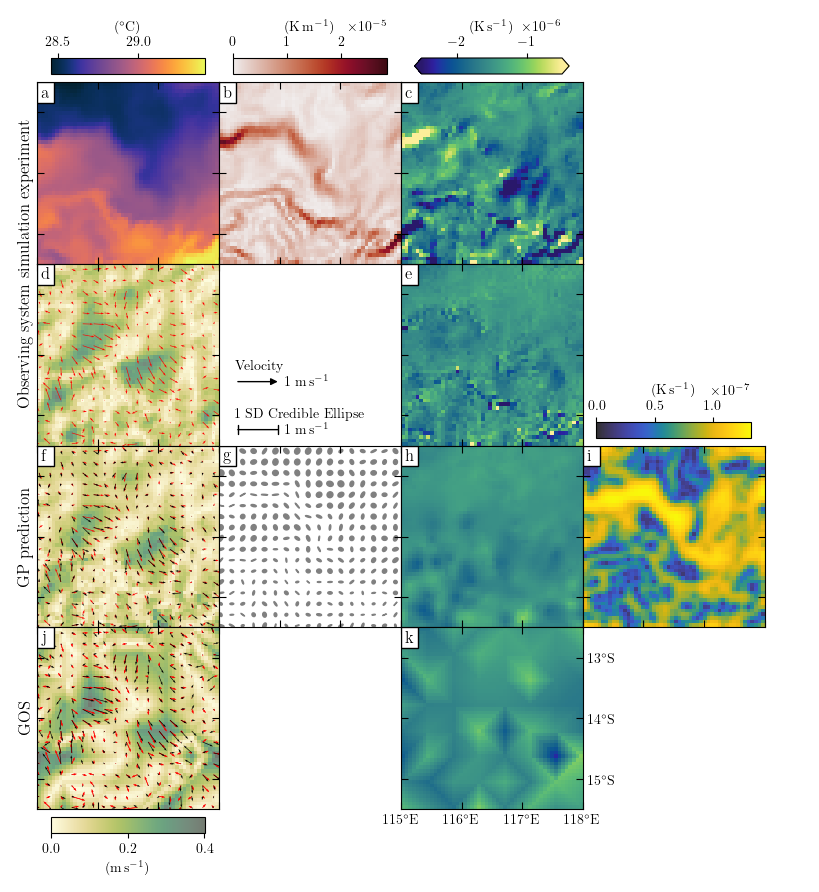

In [6]:
# Plot predictions
plot_helper.plot_predictions_osse(
    LON,
    LAT,
    To,
    dTds1o,
    dTds2o,
    dTdto,
    muSstar,
    Kxstar_vel,
    stdSstar,
    muustar,
    muvstar,
    lonlims,
    latlims,
    u=u,
    v=v,
    S=S,
    ugos=ugos,
    vgos=vgos,
    Sgos=Sgos,
    pscale=4,
    nx=17,
    ny=17,
    plimdTdt=[-2.5e-6, -0.5e-6],
)

In [7]:
# Store transect data
transect_fully_observed = {
    "lon": lon,
    "maskc": np.isnan(To[25,:]),
    "v": v[25,:],
    "muvstar": muvstar[25,:],
    "stdvstar": stdvstar[25,:],
}

### 2. Measurement error

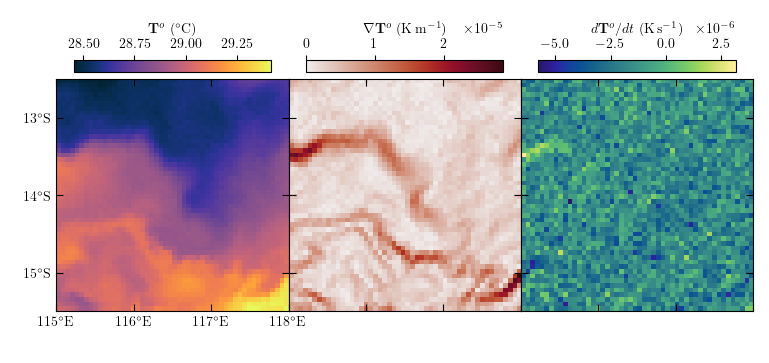

In [8]:
# Load dataset
noise = .005
ds = xr.open_dataset("data/suntans_measurement_error.nc").sel(noise = noise)
time_step = ds.time_step.item()
lon, lat, To, dTdto, u, v, S = (
    ds[var].values for var in ("lon", "lat", "T", "dTdt", "u", "v", "S")
)
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)
plot_helper.visualize_data(LON, LAT, To, dTdto, dTds1o, dTds2o, lonlims=lonlims, latlims=latlims)

In [9]:
# GP regression
params_fully_obs_gp = utils.extract_params(
    "outputs/noise_gp_obs_t.csv", "noise_sd", noise, type="gp"
)
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, params_fully_obs_gp, X, Y, time_step
    )
)
metrics_gp = metrics.overview(
    u, v, muustar, muvstar, stdustar, stdvstar, print_bool=True
)

RMSE       : 0.07048
rho_mag    : 0.6906
phi        : -6.263
crps_norm  : 0.03989
coverage90 : 0.857


In [10]:
# Global optimal solution
n_gos = int(utils.extract_params("outputs/noise_gos_t.csv", "noise_sd",noise,type="gos")["n"])
ugos, vgos, Sgos = other_methods.calculate_prediction_gos(dTds1o, dTds2o, dTdto, n_gos)
metrics_gos = metrics.overview(u, v, ugos, vgos, print_bool=True)

RMSE       : 0.09402
rho_mag    : 0.4119
phi        : -8.94


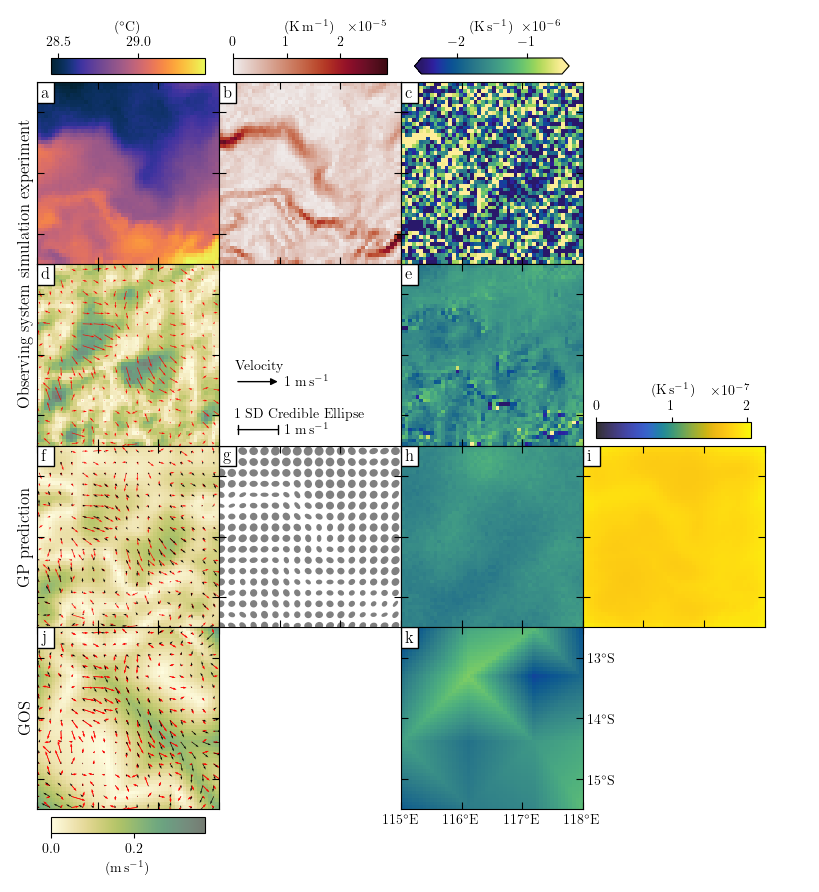

In [11]:
# Plot predictions
plot_helper.plot_predictions_osse(
    LON,
    LAT,
    To,
    dTds1o,
    dTds2o,
    dTdto,
    muSstar,
    Kxstar_vel,
    stdSstar,
    muustar,
    muvstar,
    lonlims,
    latlims,
    u=u,
    v=v,
    S=S,
    ugos=ugos,
    vgos=vgos,
    Sgos=Sgos,
    pscale=4,
    nx=17,
    ny=17,
    plimdTdt=[-2.5e-6, -0.5e-6],
)

In [12]:
# Store transect data
transect_measurement_error = {
    "lon": lon,
    "maskc": np.isnan(To[25,:]),
    "v": v[25,:],
    "muvstar": muvstar[25,:],
    "stdvstar": stdvstar[25,:],
}

### 3. Dense cloud

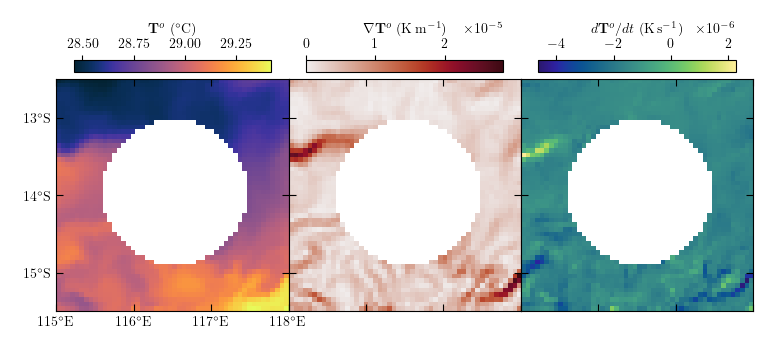

In [13]:
# Load dataset
coverage_dense = .3
ds = xr.open_dataset("data/suntans_dense_cloud.nc").sel(coverage_dense = coverage_dense)
time_step = ds.time_step.item()
lon, lat, To, dTdto, u, v, S = (
    ds[var].values for var in ("lon", "lat", "T", "dTdt", "u", "v", "S")
)
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)
plot_helper.visualize_data(LON, LAT, To, dTdto, dTds1o, dTds2o, lonlims=lonlims, latlims=latlims)

In [14]:
# GP regression
params_fully_obs_gp = utils.extract_params(
    "outputs/cloud_dense_gp_obs_t.csv", "coverage_dense", coverage_dense, type="gp"
)
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, params_fully_obs_gp, X, Y, time_step
    )
)
metrics_gp = metrics.overview(
    u, v, muustar, muvstar, stdustar, stdvstar, print_bool=True
)

RMSE       : 0.07035
rho_mag    : 0.6901
phi        : -6.366
crps_norm  : 0.03753
coverage90 : 0.8434


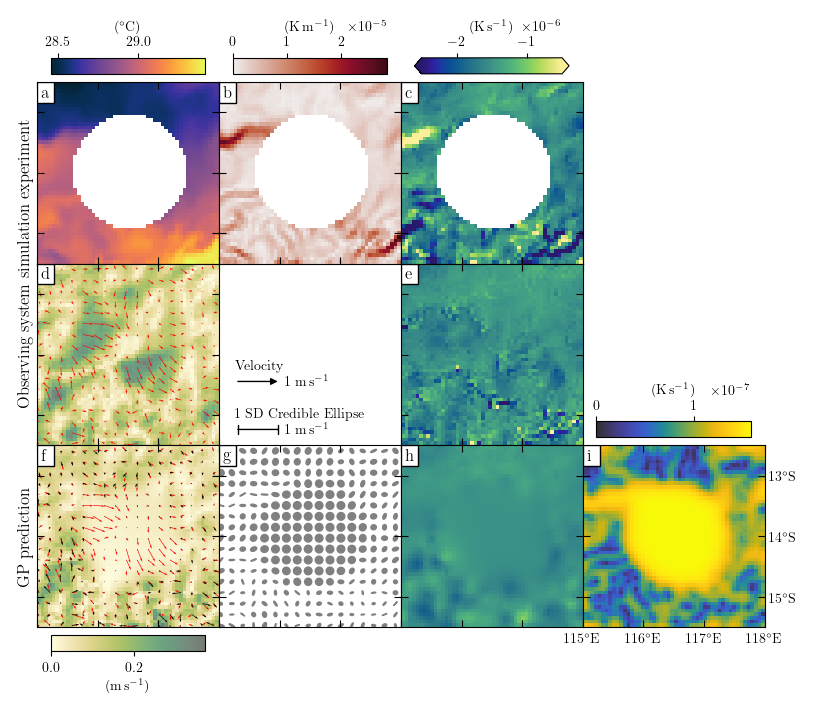

In [15]:
# Plot predictions
plot_helper.plot_predictions_osse(
    LON,
    LAT,
    To,
    dTds1o,
    dTds2o,
    dTdto,
    muSstar,
    Kxstar_vel,
    stdSstar,
    muustar,
    muvstar,
    lonlims,
    latlims,
    u=u,
    v=v,
    S=S,
    pscale=4,
    nx=17,
    ny=17,
    plimdTdt=[-2.5e-6, -0.5e-6],
)

In [16]:
# Store transect data
transect_dense_cloud = {
    "lon": lon,
    "maskc": np.isnan(To[25,:]),
    "v": v[25,:],
    "muvstar": muvstar[25,:],
    "stdvstar": stdvstar[25,:],
}

### 4. Sparse cloud

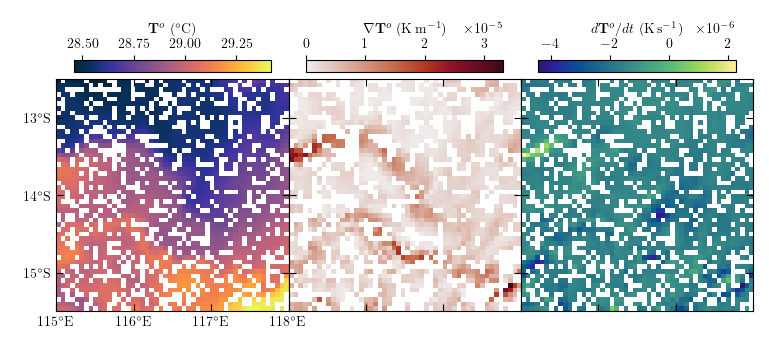

In [17]:
# Load dataset
coverage_sparse = .3
ds = xr.open_dataset("data/suntans_sparse_cloud.nc").sel(coverage_sparse = coverage_sparse)
time_step = ds.time_step.item()
lon, lat, To, dTdto, u, v, S = (
    ds[var].values for var in ("lon", "lat", "T", "dTdt", "u", "v", "S")
)
lonc, latc, X, Y, LON, LAT = utils.calculate_grid_properties(lon, lat)
dTds1o, dTds2o = utils.finite_difference_2d(X, Y, To)
plot_helper.visualize_data(LON, LAT, To, dTdto, dTds1o, dTds2o, lonlims=lonlims, latlims=latlims)

In [18]:
# GP regression
params_fully_obs_gp = utils.extract_params(
    "outputs/cloud_sparse_gp_obs_t.csv", "coverage_sparse", coverage_sparse, type="gp"
)
muustar, muvstar, muSstar, stdustar, stdvstar, stdSstar, Kxstar_vel = (
    gp_regression.calculate_prediction_gpregression(
        dTds1o, dTds2o, dTdto, params_fully_obs_gp, X, Y, time_step
    )
)
metrics_gp = metrics.overview(
    u, v, muustar, muvstar, stdustar, stdvstar, print_bool=True
)

RMSE       : 0.06764
rho_mag    : 0.7298
phi        : -2.762
crps_norm  : 0.03822
coverage90 : 0.7726


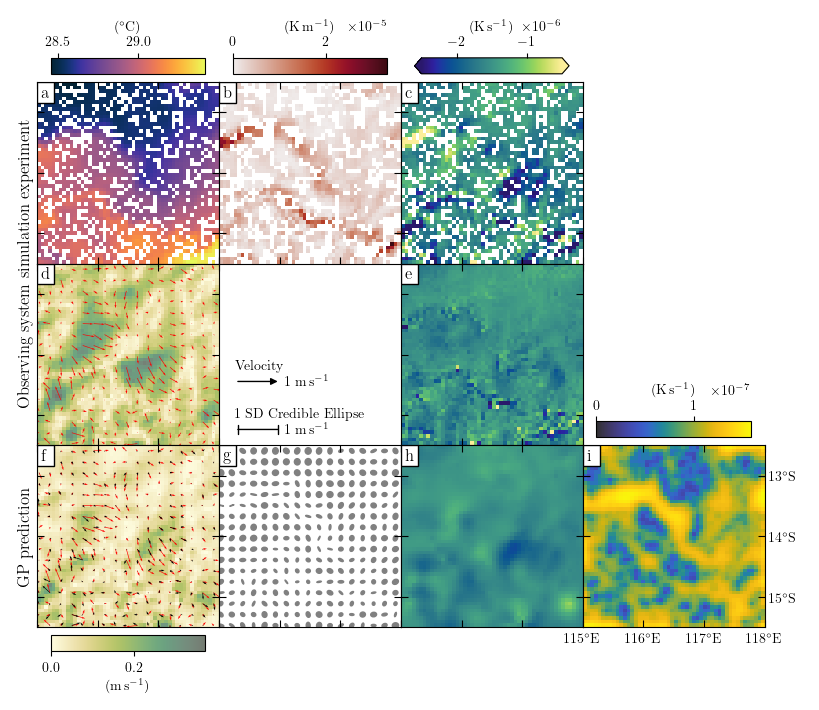

In [19]:
# Plot predictions
plot_helper.plot_predictions_osse(
    LON,
    LAT,
    To,
    dTds1o,
    dTds2o,
    dTdto,
    muSstar,
    Kxstar_vel,
    stdSstar,
    muustar,
    muvstar,
    lonlims,
    latlims,
    u=u,
    v=v,
    S=S,
    pscale=4,
    nx=17,
    ny=17,
    plimdTdt=[-2.5e-6, -0.5e-6],
)

In [20]:
# Store transect data
transect_sparse_cloud = {
    "lon": lon,
    "maskc": np.isnan(To[25,:]),
    "v": v[25,:],
    "muvstar": muvstar[25,:],
    "stdvstar": stdvstar[25,:],
}

### 5. Combine transects

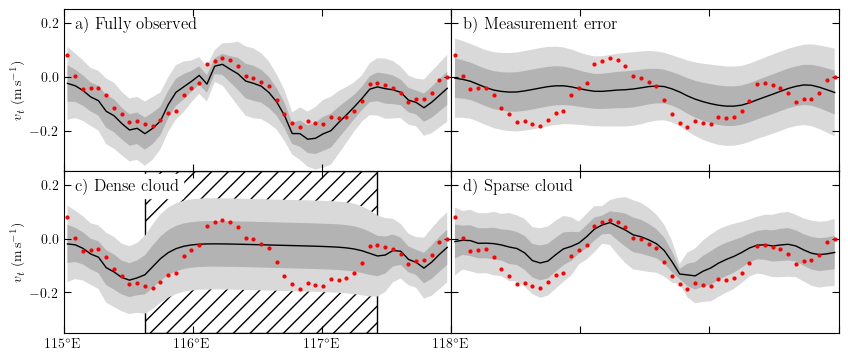

In [21]:
plot_helper.plot_transects(
    transect_fully_observed,
    transect_measurement_error,
    transect_dense_cloud,
    transect_sparse_cloud,
    lonlims,
    [-0.35, 0.25],
)